*Portions of the Python code, including data cleaning, data preparation, and segments of the regression analysis, have been adapted from the Stata code provided in Kaboski and Townsend's paper:*

Kaboski, Joseph P., and Robert M. Townsend. "The Impact of Credit on Village Economies." *American Economic Journal: Applied Economics* 4, no. 2 (2012): 98–133. https://doi.org/10.1257/app.4.2.98.

## Data Cleaning

In [112]:
import pandas as pd
import numpy as np
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Load the Stata data file
df = pd.read_stata('AnnualData_ShortSample.dta')

# Sort the DataFrame by 'case_id'
df.sort_values('case_id', inplace=True)

# Create total investment variable 'tinv'
df['tinv'] = df[['hinv', 'finv', 'pinv', 'binv', 'bafdn', 'sinv', 'safdn', 'lvcn', 'lvnn', 'lvdep']].sum(axis=1)

# Create total wages paid 'twage'
df['twage'] = df['frmwage'] + df['shrwage'] + df['buswage']

# Drop 'frmwage', 'shrwage', and 'buswage' columns
df.drop(columns=['frmwage', 'shrwage', 'buswage'], inplace=True)

# Create 'farm' variable based on 'och' values
df['farm'] = ((df['och'] > -5) & (df['och'] <= 15)).astype(int)

# Create total business investment variable 'tbinv'
df['tbinv'] = df[['pinv', 'binv', 'bafdn', 'sinv', 'safdn']].sum(axis=1)

# Create age squared 'age2h'
df['age2h'] = df['ageh'] ** 2

# Create lands squared 'gassd2'
df['gassd2'] = df['gassd'] ** 2

# Create log of assets 'lgassd'
df['lgassd'] = np.log(df['gassd'])

# Create dlog assets 'dlgassd1' (log difference of gassd)
df['dlgassd1'] = df.groupby('case_id')['gassd'].transform(lambda x: np.log(x.shift(-1) / x))

# Create dnetinc (log difference of netinc)
df['dnetinc'] = df.groupby('case_id')['netinc'].transform(lambda x: np.log(x.shift(-1) / x))

# Create the log of the number of households in the village 'invHH'
df['invHH'] = 1 / df['vHH']

# Replace 'invHH' for year == 1 with the value from the next year (shifted)
df.loc[df['year'] == 1, 'invHH'] = df.groupby('case_id')['invHH'].transform(lambda x: x.shift(-1))

# Create log of the number of households in the village for the previous year 'invHHl'
df['invHHl'] = df.groupby('case_id')['vHH'].transform(lambda x: 1 / x.shift(1))

# Create 'vfstl' which is the value of 'vfst' from the previous year
df['vfstl'] = df.groupby('case_id')['vfst'].transform(lambda x: x.shift(1))

# Create 'bsnew' by summing 'bnew' and 'snew'
df['bsnew'] = df['bnew'] + df['snew']

# Specify the list of columns to keep
columns_to_keep = [
    'case_id', 'year', 'frmpro', 'buspro', 'wageinc', 'riceinc', 'cropinc', 'liveinc', 
    'educ', 'invHHl', 'vfstl', 'invHH', 'changwat', 'amphoe', 'tambon', 'village', 
    'dnetinc', 'dlgassd1', 'farm', 'netinc', 'bsnew', 'tc', 'educ', 'grain', 'milk', 
    'meat', 'alch1', 'alch2', 'fuel', 'tobac', 'cerem', 'houserep', 'vehicrep', 
    'clothes', 'mealaway', 'ageh', 'madult', 'fadult', 'kids', 'maleh', 'finv', 
    'tbinv', 'hinv', 'frtexp', 'netinc', 'lac', 'newst', 'vfst', 'infst', 'baacst', 
    'cbst', 'const', 'edust', 'agst', 'hhast', 'busst', 'frtst', 'age2h', 'educh', 
    'gassd', 'gassd2', 'lgassd', 'rst', 'defcr', 'twage'
]

# Keep only the specified columns
df = df[columns_to_keep]

# Create 'villageyear' by dividing 'case_id' by 1000 and converting to an integer
df['villageyear'] = (df['case_id'] // 1000).astype(int)

# Replace 'vfst' by dividing by 10000
df['vfst'] = df['vfst'] / 10000

# Replace 'vfstl' by dividing by 10000
df['vfstl'] = df['vfstl'] / 10000

# Sort the DataFrame by 'case_id' and 'year'
df = df.sort_values(by=['case_id', 'year'])

# Create 'invHHim' which is 'invHH' where year is 6
df['invHHim'] = np.where(df['year'] == 6, df['invHH'], np.nan)

# Create 'invHHi' as the mean of 'invHHim' within each 'case_id' group
df['invHHi'] = df.groupby('case_id')['invHHim'].transform('mean')

# Create 'vHHi' as the inverse of 'invHHi'
df['vHHi'] = 1 / df['invHHi']

# Drop rows where 'vHHi' is greater than 250 or less than 50
df = df[(df['vHHi'] <= 250) & (df['vHHi'] >= 50)]

# Create 'invHHpvf' which is 'invHHi' multiplied by a boolean indicating if 'year' is greater than 5
df['invHHpvf'] = df['invHHi'] * (df['year'] > 5)

# Create 'invHHtvf1' which is 'invHHi' if 'year' equals 6
df['invHHtvf1'] = df['invHHi'] * (df['year'] == 6)

# Create 'invHHtvf2' which is 'invHHi' if 'year' equals 7
df['invHHtvf2'] = df['invHHi'] * (df['year'] == 7)

# Create 'vfstf' by multiplying 'vfst' with a condition where 'maleh' equals 0
df['vfstf'] = df['vfst'] * (df['maleh'] == 0)

# Create 'invHHtvf1f' by multiplying 'invHHtvf1' with a condition where 'maleh' equals 0
df['invHHtvf1f'] = df['invHHtvf1'] * (df['maleh'] == 0)

# Create 'invHHtvf2f' by multiplying 'invHHtvf2' with a condition where 'maleh' equals 0
df['invHHtvf2f'] = df['invHHtvf2'] * (df['maleh'] == 0)

# Create 'vfstlf' by multiplying 'vfstl' with a condition where 'maleh' equals 0
df['vfstlf'] = df['vfstl'] * (df['maleh'] == 0)

# Create a new column 'caseid' as a copy of 'case_id', ensuring it's of type float (equivalent to 'double' in Stata)
df['caseid'] = df['case_id'].astype(float)

# Drop the 'case_id' column
df.drop(columns=['case_id'], inplace=True)

# Create a binary column 'tbinvp' which is True if 'tbinv' is greater than 0
df['tbinvp'] = df['tbinv'] > 0

# Create a binary column 'finvp' which is True if 'finv' is greater than 0
df['finvp'] = df['finv'] > 0

# Create a binary column 'defcrp' which is True if 'defcr' is greater than 0
df['defcrp'] = df['defcr'] > 0

# Keep rows where 'year' is less than 8
df = df[df['year'] < 8]

## Summary Statistics

### General Summary

In [113]:
from IPython.display import display
import numpy as np
import pandas as pd

# Step 1: Create a mapping for more understandable variable names
variable_names = {
    'newst': "New Short-Term Credit",
    'vfst_post_program': "Village Fund Credit",
    'ageh': "Age of Household's Head",
    'educh': "Years of Education of Household's Head"
}

# Step 2: Create 'vfst_post_program' and 'vfst_pre_program' variables
df['vfst_post_program'] = df['vfst'].where(df['year'].isin([6, 7]), other=None)

# Step 3: Group by 'caseid' and calculate the mean for the specified variables, excluding 'farm' for the main table
collapsed_df = df.groupby('caseid')[['newst', 'vfst_post_program', 'ageh', 'educh']].mean()

# Step 4: Scale 'vfst_post_program' by 10,000 for display purposes only
collapsed_df['vfst_post_program'] = collapsed_df['vfst_post_program'] * 10000

# Step 5: Rename the columns for better readability
collapsed_df.rename(columns=variable_names, inplace=True)

# Step 6: Get the summary statistics for the collapsed data
summary_stats_interest = collapsed_df.describe()

# Step 7: Calculate cross-sectional standard deviation
cross_sectional_std = collapsed_df.std()

# Step 8: Transpose the table to make variables the rows and ensure correct order
summary_stats_transposed = summary_stats_interest.T.reindex([
    "New Short-Term Credit", 
    "Village Fund Credit",  
    "Age of Household's Head", 
    "Years of Education of Household's Head"
])

# Step 9: Add cross-sectional standard deviation to the transposed table
summary_stats_transposed['Cross-Sectional Standard Deviation'] = cross_sectional_std.reindex([
    "New Short-Term Credit", 
    "Village Fund Credit",  
    "Age of Household's Head", 
    "Years of Education of Household's Head"
])

# Step 10: Add summary statistics for the 'farm' dummy variable
farm_counts = df['farm'].value_counts().rename({0: 'Non-Farm', 1: 'Farm'})
farm_proportions = df['farm'].value_counts(normalize=True).rename({0: 'Non-Farm', 1: 'Farm'}) * 100

# Create a DataFrame for the dummy variable summary
farm_summary = pd.DataFrame({
    'Count': farm_counts,
    'Proportion (%)': farm_proportions
})

summary_stats_transposed

,count,mean,std,min,25%,50%,75%,max,Cross-Sectional Standard Deviation
New Short-Term Credit,725.0,21831.071823,35763.352405,0.0,3571.428571,10857.142857,28321.428571,528285.714286,35763.352405
Village Fund Credit,725.0,9326.689655,8626.174438,0.0,0.000000,10000.000000,16500.000000,50000.000000,8626.174438
Age of Household's Head,725.0,53.864456,12.966987,26.0,43.000000,52.571430,63.571430,90.000000,12.966987
Years of Education of Household's Head,722.0,6.123309,3.003530,0.0,6.428571,6.571429,6.571429,16.000000,3.003530


In [114]:
farm_summary

,Count,Proportion (%)
farm,,
Farm,3248,64.0
Non-Farm,1827,36.0


### Age of Household's Head

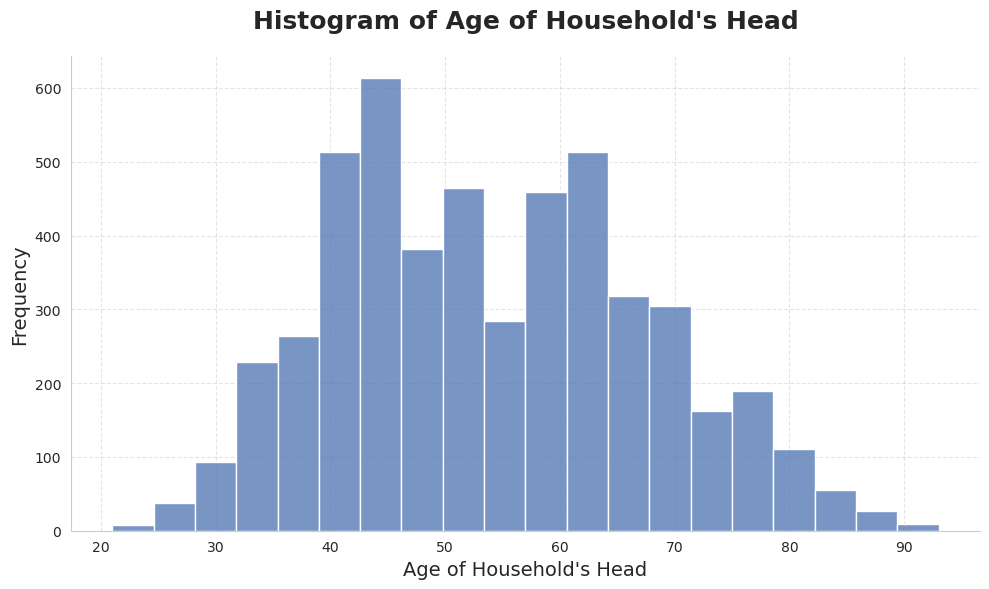

In [115]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a sleek seaborn style
sns.set_style("whitegrid")

# Extract the relevant 'ageh' column (Age of Household Head)
ageh_data = df['ageh'].dropna()

# Plot the histogram of age
plt.figure(figsize=(10, 6))

# Plot histogram with softer color and edge
sns.histplot(ageh_data, bins=20, kde=False, color='#4c72b0', edgecolor='white')

# Customize the plot with a cleaner look
plt.title("Histogram of Age of Household's Head", fontsize=18, weight='bold', pad=20)
plt.xlabel("Age of Household's Head", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Remove the top and right spines for a cleaner look
sns.despine()

# Subtle gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve spacing
plt.tight_layout()

# Display the plot
plt.show()

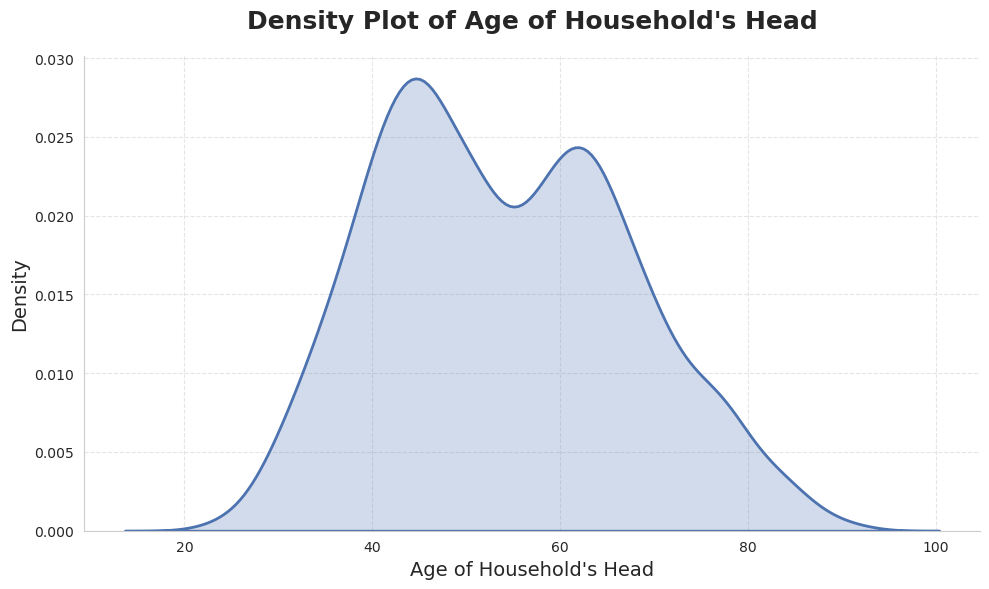

In [116]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set a sleek seaborn style
sns.set_style("whitegrid")

# Create a density plot for 'ageh'
plt.figure(figsize=(10, 6))

# Plot the density with a modern blue-gray color and shading
sns.kdeplot(df['ageh'].dropna(), shade=True, color='#4c72b0', lw=2)

# Add labels and title with a clean look
plt.title("Density Plot of Age of Household's Head", fontsize=18, weight='bold', pad=20)
plt.xlabel("Age of Household's Head", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Remove top and right spines for a sleek look
sns.despine()

# Subtle gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve spacing
plt.tight_layout()

# Show the plot
plt.show()

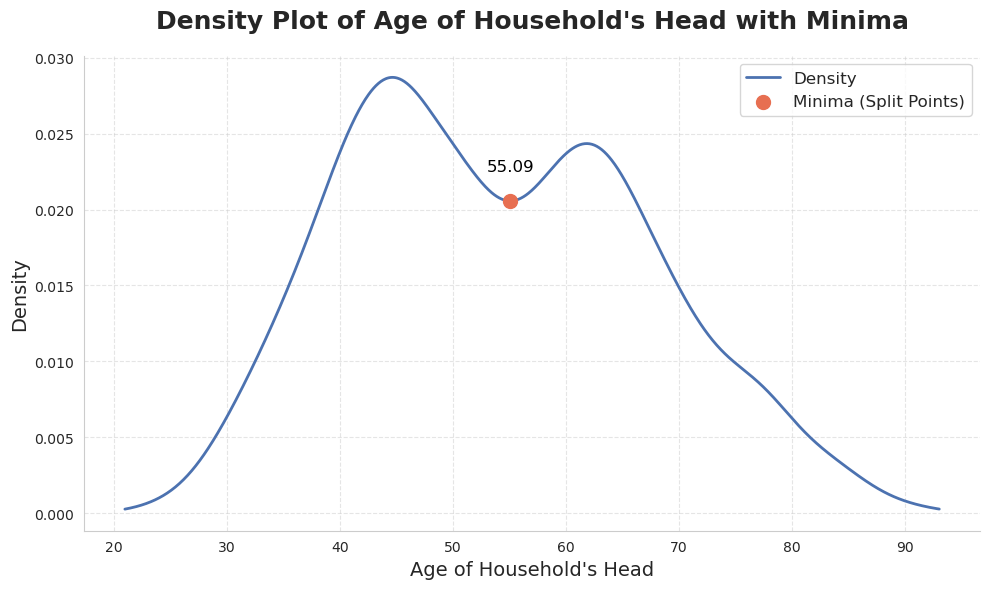

Split points (minima) in the distribution: [55.09009009]


In [117]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Extract the relevant 'ageh' column (Age of Household Head)
ageh_data = df['ageh'].dropna()

# Create a density estimate using Gaussian Kernel Density Estimation
kde = gaussian_kde(ageh_data)
age_range = np.linspace(ageh_data.min(), ageh_data.max(), 1000)
density_values = kde(age_range)

# Find the local minima (the split points)
minima_indices = find_peaks(-density_values)[0]
minima_ages = age_range[minima_indices]

# Plot the density and mark the minima
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot the density line with modern blue-gray color
plt.plot(age_range, density_values, color='#4c72b0', lw=2, label='Density')

# Highlight the minima with a sleek red marker
plt.scatter(minima_ages, density_values[minima_indices], color='#e76f51', zorder=5, s=100, label='Minima (Split Points)')

# Add plot annotations and labels
for i, age in enumerate(minima_ages):
    plt.text(age, density_values[minima_indices][i] + 0.002, f'{age:.2f}', fontsize=12, color='black', ha='center')

# Customize the plot for a modern, sleek look
plt.title("Density Plot of Age of Household's Head with Minima", fontsize=18, weight='bold', pad=20)
plt.xlabel("Age of Household's Head", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Remove top and right spines for a cleaner look
sns.despine()

# Add a legend
plt.legend(fontsize=12)

# Improve spacing and layout
plt.tight_layout()

# Show the plot
plt.show()

# Print the minima for your reference
print(f"Split points (minima) in the distribution: {minima_ages}")

In [118]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Extract the relevant 'ageh' column (Age of Household Head)
ageh_data = df['ageh'].dropna()

# Create a density estimate using Gaussian Kernel Density Estimation
kde = gaussian_kde(ageh_data)
age_range = np.linspace(ageh_data.min(), ageh_data.max(), 1000)
density_values = kde(age_range)

# Find the local minima (the split points)
minima_indices = find_peaks(-density_values)[0]
minima_ages = age_range[minima_indices]

# Use the first (and only) split point for grouping
split_age = minima_ages[0]

# Create a new column to categorize ages into 'Young' and 'Old'
df['age_group'] = np.where(df['ageh'] <= split_age, 'Young', 'Old')

# Compute summary statistics for each group
summary_stats = df.groupby('age_group')['ageh'].describe()

# Rename both the index and the columns
summary_stats.rename(columns={
    'count': 'Count',
    'mean': 'Mean',
    'std': 'Std Dev',
    'min': 'Min',
    '25%': '25%',
    '50%': 'Median',
    '75%': '75%',
    'max': 'Max'
}, inplace=True)

summary_stats.index.name = 'Age Group'

# Display the updated summary statistics
summary_stats.style.set_caption("Summary Statistics for Age Groups").format("{:.2f}")

,Count,Mean,Std Dev,Min,25%,Median,75%,Max
Age Group,,,,,,,,
Old,2245.00,66.58,7.69,56.00,61.00,65.00,71.00,93.00
Young,2792.00,43.73,6.83,21.00,39.00,44.00,49.00,55.00


### Years of Education of Household Head

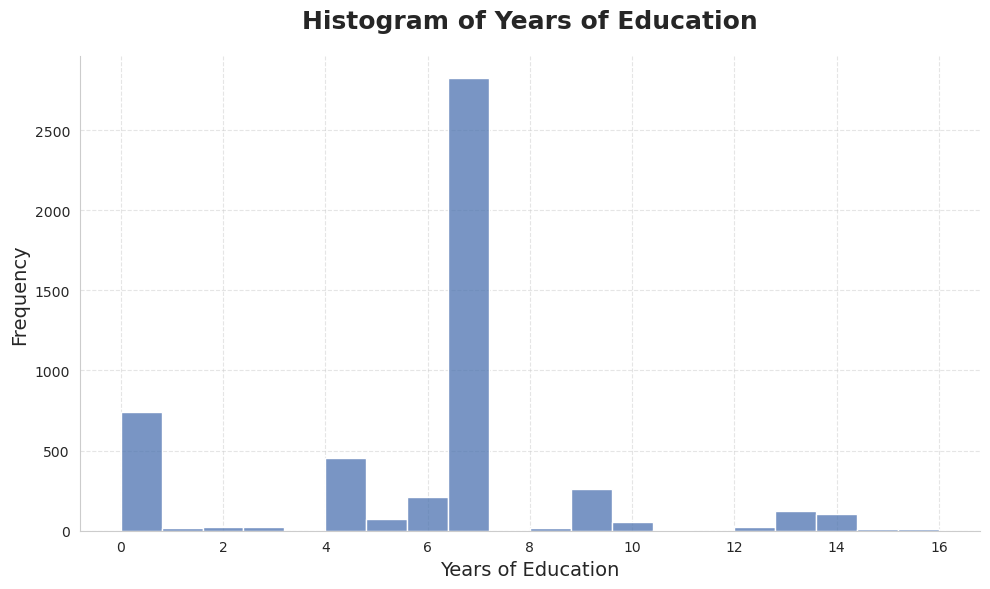

In [119]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a sleek seaborn style
sns.set_style("whitegrid")

# Extract the relevant 'educh' column (Years of Education of Household Head)
educh_data = df['educh'].dropna()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histogram with modern color and white edges
sns.histplot(educh_data, bins=20, kde=False, color='#4c72b0', edgecolor='white')

# Customize the plot with a clean, modern look
plt.title("Histogram of Years of Education", fontsize=18, weight='bold', pad=20)
plt.xlabel("Years of Education", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Remove top and right spines for a sleek look
sns.despine()

# Subtle gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve spacing
plt.tight_layout()

# Display the plot
plt.show()

In [120]:
# Import necessary libraries
import numpy as np
import pandas as pd


# Define the buckets for education levels
bins = [0, 4, 8, 16]
labels = ['Low (0-4 years)', 'Medium (5-8 years)', 'High (9-16 years)']

# Create a new column 'education_bucket' for the defined buckets
df['education_bucket'] = pd.cut(df['educh'], bins=bins, labels=labels, include_lowest=True)

# Display summary statistics for each education bucket
summary_stats_buckets = df.groupby('education_bucket')['educh'].describe()

# Rename both the index and the columns
summary_stats_buckets.rename(columns={
    'count': 'Count',
    'mean': 'Mean',
    'std': 'Std Dev',
    'min': 'Min',
    '25%': '25%',
    '50%': 'Median',
    '75%': '75%',
    'max': 'Max'
}, inplace=True)

summary_stats_buckets.index.name = 'Education Group'

# Optionally, you can display the summary statistics in a visually styled table using pandas Styler
summary_stats_buckets.style.set_caption("Summary Statistics for Education Buckets").format("{:.2f}")

,Count,Mean,Std Dev,Min,25%,Median,75%,Max
Education Group,,,,,,,,
Low (0-4 years),1255.00,1.54,1.90,0.00,0.00,0.00,4.00,4.00
Medium (5-8 years),3124.00,6.89,0.40,5.00,7.00,7.00,7.00,8.00
High (9-16 years),588.00,11.16,2.22,9.00,9.00,10.00,13.00,16.00


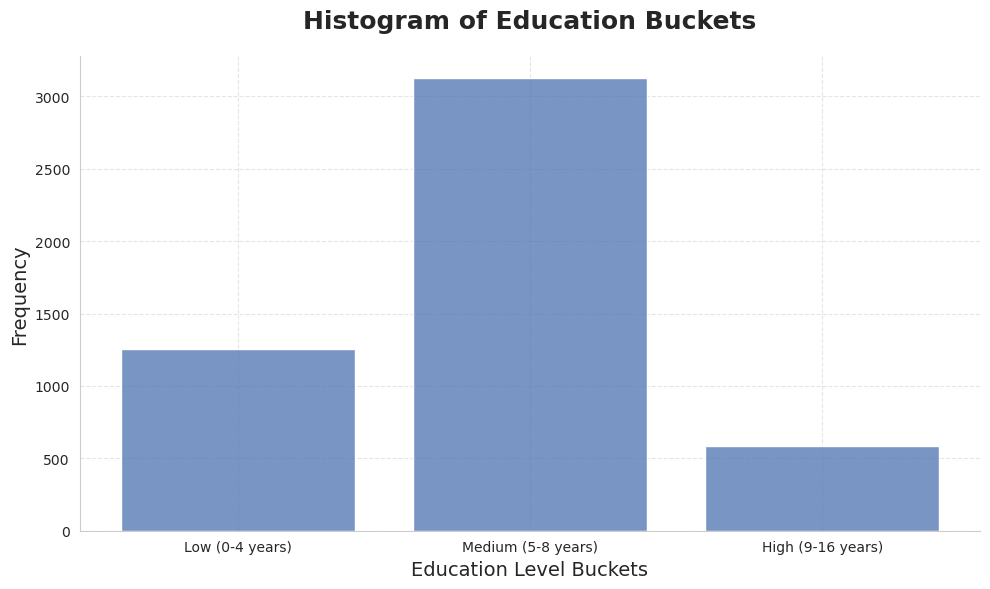

In [121]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set a sleek seaborn style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histogram for the education buckets with modern style, narrower bars
sns.histplot(df['education_bucket'], color='#4c72b0', edgecolor='white', shrink=0.8)

# Customize the plot with a clean, modern look
plt.title("Histogram of Education Buckets", fontsize=18, weight='bold', pad=20)
plt.xlabel("Education Level Buckets", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Remove top and right spines for a sleek look
sns.despine()

# Subtle gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve spacing
plt.tight_layout()

# Display the plot
plt.show()

### Farmer Status

In [122]:
# Import necessary libraries
import numpy as np
import pandas as pd

# Create a new column 'farmer_status' to distinguish farmers (1) and non-farmers (0)
df['farmer_status'] = np.where(df['farm'] == 1, 'Farmer', 'Non-Farmer')

# Display summary statistics for both farmers and non-farmers
summary_stats_farmers = df.groupby('farmer_status')['farm'].describe()

# Rename both the index and the columns
summary_stats_farmers.rename(columns={
    'count': 'Count',
    'mean': 'Mean',
    'std': 'Std Dev',
    'min': 'Min',
    '25%': '25%',
    '50%': 'Median',
    '75%': '75%',
    'max': 'Max'
}, inplace=True)

summary_stats_farmers.index.name = 'Farmer Status'

# Optionally, you can display the summary statistics in a visually styled table using pandas Styler
summary_stats_farmers.style.set_caption("Summary Statistics for Farmers and Non-Farmers").format("{:.2f}")

,Count,Mean,Std Dev,Min,25%,Median,75%,Max
Farmer Status,,,,,,,,
Farmer,3248.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
Non-Farmer,1827.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


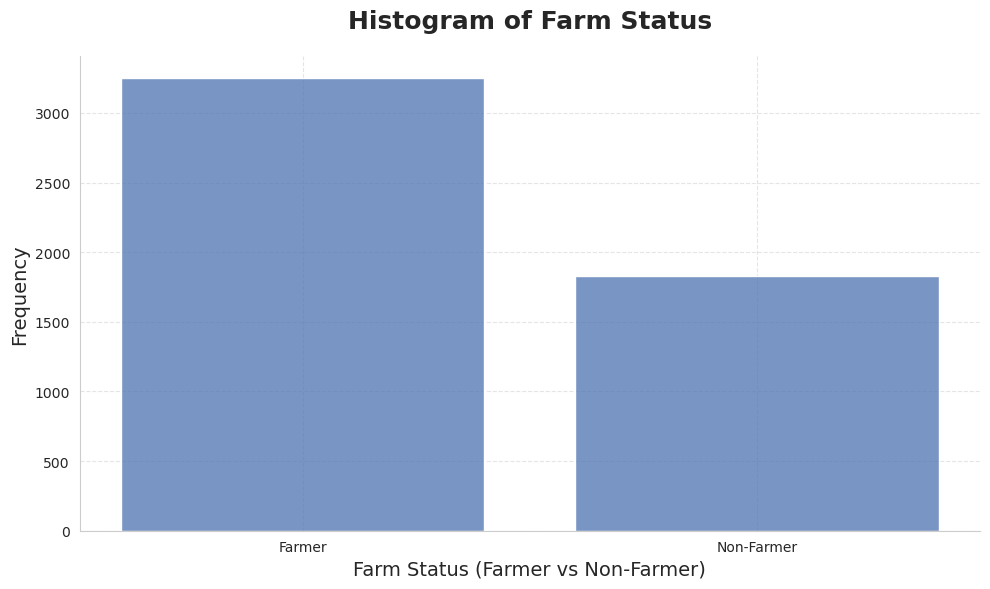

In [123]:
# It seems the 'farmer_status' column wasn't created successfully, let's create it again and then plot

# Create a new column 'farmer_status' to distinguish farmers (1) and non-farmers (0)
df['farmer_status'] = np.where(df['farm'] == 1, 'Farmer', 'Non-Farmer')

# Create the plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot histogram for the farm status with modern style, narrower bars
sns.histplot(df['farmer_status'], color='#4c72b0', edgecolor='white', shrink=0.8)

# Customize the plot with a clean, modern look
plt.title("Histogram of Farm Status", fontsize=18, weight='bold', pad=20)
plt.xlabel("Farm Status (Farmer vs Non-Farmer)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Remove top and right spines for a sleek look
sns.despine()

# Subtle gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve spacing
plt.tight_layout()

# Display the plot
plt.show()

## IV 2SLS Regression

### First Stage Regression (IV)

In [124]:
import pandas as pd
from linearmodels.panel import PanelOLS

# Convert 'year' to numeric type to avoid the time index error
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['caseid'] = df['caseid'].astype('category')

# Set index to 'caseid' and 'year', and make sure the index levels are named
df = df.set_index(['caseid', 'year'])
df.index.names = ['caseid', 'year']

# Reset the index to treat 'caseid' and 'year' as regular columns for merging the year dummies
df_reset = df.reset_index()

# Manually creabte year dummies using pandas, and drop the first category (year 1)
year_dummies = pd.get_dummies(df_reset['year'], prefix='year', drop_first=True)

# Add the year dummies to the dataframe
df_reset = df_reset.join(year_dummies)

# Set the index back to 'caseid' and 'year' after adding the dummies
df_reset = df_reset.set_index(['caseid', 'year'])

# Define the formula for the first stage regression, now using the manually created year dummies
formula = 'vfst ~ invHHtvf1 + invHHtvf2 + madult + fadult + kids + maleh + farm + ageh + age2h + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the fixed effects model
model = PanelOLS.from_formula(formula, df_reset)

# Fit the model with robust standard errors and clustering by 'villageyear'
result = model.fit(cov_type='clustered', clusters=df_reset['villageyear'])

# Store the predicted values from the first stage
df_reset['vfst_hat'] = result.fitted_values

# Print the summary of the results
print(result.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   vfst   R-squared:                        0.4662
Estimator:                   PanelOLS   R-squared (Between):             -4.1024
No. Observations:                4967   R-squared (Within):               0.4662
Date:                Sun, Nov 03 2024   R-squared (Overall):             -0.6669
Time:                        04:38:49   Log-likelihood                   -3322.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      230.88
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(16,4229)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             66.343
                            

### Second-Stage Age Regression

In [125]:
# Ensure 'age_group' is a categorical variable
df_reset['age_group'] = df_reset['age_group'].astype('category')

# Create an interaction term for 'vfst_hat' with 'age_group' where Old is the base case
df_reset['vfst_hat_Young'] = df_reset['vfst_hat'] * (df_reset['age_group'] == 'Young').astype(int)

# Define the formula for the second stage regression, excluding ageh and age2h, and using Old as the base case
formula = 'newst ~ vfst_hat_Young + madult + fadult + kids + maleh + farm + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the second stage model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_age = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_age.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0195
Estimator:                   PanelOLS   R-squared (Between):              0.2739
No. Observations:                4967   R-squared (Within):               0.0195
Date:                Sun, Nov 03 2024   R-squared (Overall):              0.1567
Time:                        04:38:50   Log-likelihood                -5.955e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.4851
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(13,4232)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             6.1564
                            

### Second-Stage Education Regression

In [126]:
# Ensure 'education_bucket' is a categorical variable
df_reset['education_bucket'] = df_reset['education_bucket'].astype('category')

# Create interaction terms for 'vfst_hat' with each education bucket, using Low as the base case
df_reset['vfst_hat_Medium'] = df_reset['vfst_hat'] * (df_reset['education_bucket'] == 'Medium (5-8 years)').astype(int)
df_reset['vfst_hat_High'] = df_reset['vfst_hat'] * (df_reset['education_bucket'] == 'High (9-16 years)').astype(int)

# Define the formula for the second stage regression, using Low as the base case
formula = 'newst ~ vfst_hat_Medium + vfst_hat_High + madult + fadult + kids + maleh + farm + ageh + age2h + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the second stage model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_education = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_education.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0199
Estimator:                   PanelOLS   R-squared (Between):              0.0161
No. Observations:                4967   R-squared (Within):               0.0199
Date:                Sun, Nov 03 2024   R-squared (Overall):              0.0224
Time:                        04:38:50   Log-likelihood                -5.955e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.7384
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(15,4230)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             6.6240
                            

### Second-Stage Occupation Regression

In [127]:
# Ensure 'farmer_status' is a categorical variable
df_reset['farmer_status'] = df_reset['farmer_status'].astype('category')

# Create interaction term for 'vfst_hat' with 'farmer_status', using Farmer as the base case
df_reset['vfst_hat_NonFarmer'] = df_reset['vfst_hat'] * (df_reset['farmer_status'] == 'Non-Farmer').astype(int)

# Define the formula for the second stage regression, using Farmer as the base case
formula = 'newst ~ vfst_hat_NonFarmer + madult + fadult + kids + maleh + ageh + age2h + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the second stage model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_occupation = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_occupation.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0183
Estimator:                   PanelOLS   R-squared (Between):             -0.0616
No. Observations:                4967   R-squared (Within):               0.0183
Date:                Sun, Nov 03 2024   R-squared (Overall):             -0.0216
Time:                        04:38:50   Log-likelihood                -5.955e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.6423
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(14,4231)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             5.4128
                            

## OLS Regression

### Age OLS

In [128]:
# Ensure 'age_group' is a categorical variable
df_reset['age_group'] = df_reset['age_group'].astype('category')

# Create an interaction term for 'vfst' with 'age_group', using Old as the base case
df_reset['vfst_Young'] = df_reset['vfst'] * (df_reset['age_group'] == 'Young').astype(int)

# Define the formula for the regression, excluding ageh and age2h, and using Old as the base case
formula = 'newst ~ vfst_Young + madult + fadult + kids + maleh + farm + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_age_ols = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_age_ols.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0363
Estimator:                   PanelOLS   R-squared (Between):              0.2854
No. Observations:                4967   R-squared (Within):               0.0363
Date:                Sun, Nov 03 2024   R-squared (Overall):              0.1704
Time:                        04:38:50   Log-likelihood                 -5.95e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.270
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(13,4232)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             8.4476
                            

### Education OLS

In [129]:
# Ensure 'education_bucket' is a categorical variable
df_reset['education_bucket'] = df_reset['education_bucket'].astype('category')

# Create interaction terms for 'vfst' with each education bucket, using Low as the base case
df_reset['vfst_Medium'] = df_reset['vfst'] * (df_reset['education_bucket'] == 'Medium (5-8 years)').astype(int)
df_reset['vfst_High'] = df_reset['vfst'] * (df_reset['education_bucket'] == 'High (9-16 years)').astype(int)

# Define the formula for the regression, using Low as the base case
formula = 'newst ~ vfst_Medium + vfst_High + madult + fadult + kids + maleh + farm + ageh + age2h + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_education_ols = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_education_ols.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0378
Estimator:                   PanelOLS   R-squared (Between):              0.2417
No. Observations:                5037   R-squared (Within):               0.0378
Date:                Sun, Nov 03 2024   R-squared (Overall):              0.1469
Time:                        04:38:50   Log-likelihood                -6.034e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.251
Entities:                         725   P-value                           0.0000
Avg Obs:                       6.9476   Distribution:                 F(15,4297)
Min Obs:                       6.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             15.497
                            

### Occupation OLS

In [130]:
# Ensure 'farmer_status' is a categorical variable
df_reset['farmer_status'] = df_reset['farmer_status'].astype('category')

# Create interaction term for 'vfst' with 'farmer_status', using Farmer as the base case
df_reset['vfst_NonFarmer'] = df_reset['vfst'] * (df_reset['farmer_status'] == 'Non-Farmer').astype(int)

# Define the formula for the regression, using Farmer as the base case
formula = 'newst ~ vfst_NonFarmer + madult + fadult + kids + maleh + ageh + age2h + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_occupation_ols = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_occupation_ols.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0228
Estimator:                   PanelOLS   R-squared (Between):              0.1139
No. Observations:                4967   R-squared (Within):               0.0228
Date:                Sun, Nov 03 2024   R-squared (Overall):              0.0734
Time:                        04:38:50   Log-likelihood                -5.954e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.0459
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(14,4231)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             5.4908
                            

## Durbin–Wu–Hausman Test

In [131]:
from linearmodels.panel import PanelOLS
from scipy.stats import chi2

def dwh_test_manual(ols_result, iv_result, df, cluster_col):
    # Obtain residuals from the 2SLS first stage
    df['iv_residuals'] = iv_result.resids
    
    # Re-run the OLS regression, adding the residuals from the IV regression as a regressor
    formula = ols_result.model.formula + ' + iv_residuals'
    aux_ols_model = PanelOLS.from_formula(formula, df)
    aux_ols_result = aux_ols_model.fit(cov_type='clustered', clusters=df[cluster_col])
    
    # Calculate the test statistic
    residual_coef = aux_ols_result.params['iv_residuals']
    residual_se = aux_ols_result.std_errors['iv_residuals']
    dwh_statistic = (residual_coef / residual_se) ** 2
    p_value = 1 - chi2.cdf(dwh_statistic, 1)
    
    return dwh_statistic, p_value

# Age Regression DWH Test
dwh_age_stat, dwh_age_pval = dwh_test_manual(result2_age_ols, result2_age, df_reset, 'villageyear')
print("Age Regression DWH Test")
print(f"DWH Statistic: {dwh_age_stat}, P-value: {dwh_age_pval}\n")

# Education Regression DWH Test
dwh_edu_stat, dwh_edu_pval = dwh_test_manual(result2_education_ols, result2_education, df_reset, 'villageyear')
print("Education Regression DWH Test")
print(f"DWH Statistic: {dwh_edu_stat}, P-value: {dwh_edu_pval}\n")

# Occupation Regression DWH Test
dwh_occ_stat, dwh_occ_pval = dwh_test_manual(result2_occupation_ols, result2_occupation, df_reset, 'villageyear')
print("Occupation Regression DWH Test")
print(f"DWH Statistic: {dwh_occ_stat}, P-value: {dwh_occ_pval}\n")

# Interpretation
for category, p_value in zip(["Age", "Education", "Occupation"], [dwh_age_pval, dwh_edu_pval, dwh_occ_pval]):
    if p_value < 0.05:
        print(f"{category} Regression: Reject the null hypothesis (Evidence of endogeneity)")
    else:
        print(f"{category} Regression: Fail to reject the null hypothesis (No evidence of endogeneity)")

Age Regression DWH Test
DWH Statistic: 1231095.5864259386, P-value: 0.0

Education Regression DWH Test
DWH Statistic: 1410911.1374518615, P-value: 0.0

Occupation Regression DWH Test
DWH Statistic: 2845455.5761737027, P-value: 0.0

Age Regression: Reject the null hypothesis (Evidence of endogeneity)
Education Regression: Reject the null hypothesis (Evidence of endogeneity)
Occupation Regression: Reject the null hypothesis (Evidence of endogeneity)


## DAG Models

In [132]:
from graphviz import Digraph

def create_updated_dag(subgroup, interaction_label):
    dag = Digraph(comment=f'{subgroup} Regression DAG', format='png')
    
    # Nodes
    dag.node('IV', 'Inverse Village Size')
    dag.node('PVFC', 'Predicted Village Fund Credit')
    dag.node(interaction_label, interaction_label)  # Interaction term based on subgroup
    dag.node('NSC', 'New Short-Term Credit')
    dag.node('C', 'Control Variables')
    dag.node('F', 'Year & Village Fixed Effects')

    # Edges
    dag.edge('IV', 'PVFC', label=" Instrument")
    dag.edge('PVFC', interaction_label, label=" Predicted Values")
    dag.edge(interaction_label, 'NSC', xlabel="Interaction Effect             ")
    dag.edge('C', 'NSC', label=" Controls")
    dag.edge('F', 'NSC', label=" Fixed Effects")

    return dag

# Create DAGs for each subgroup with updated labels and structure
dag_age = create_updated_dag('Age', 'Predicted Village Fund Credit x Young')
dag_medium = create_updated_dag('Medium Education', 'Predicted Village Fund Credit x Medium')
dag_high = create_updated_dag('High Education', 'Predicted Village Fund Credit x High')
dag_occupation = create_updated_dag('Occupation', 'Predicted Village Fund Credit x Non-Farmer')

# Save and render the DAGs
dag_age.render(filename='age_dag')
dag_medium.render(filename='medium_education_dag')
dag_high.render(filename='high_education_dag')
dag_occupation.render(filename='occupation_dag')

'occupation_dag.png'

## Variable Selection

### Decision Tree

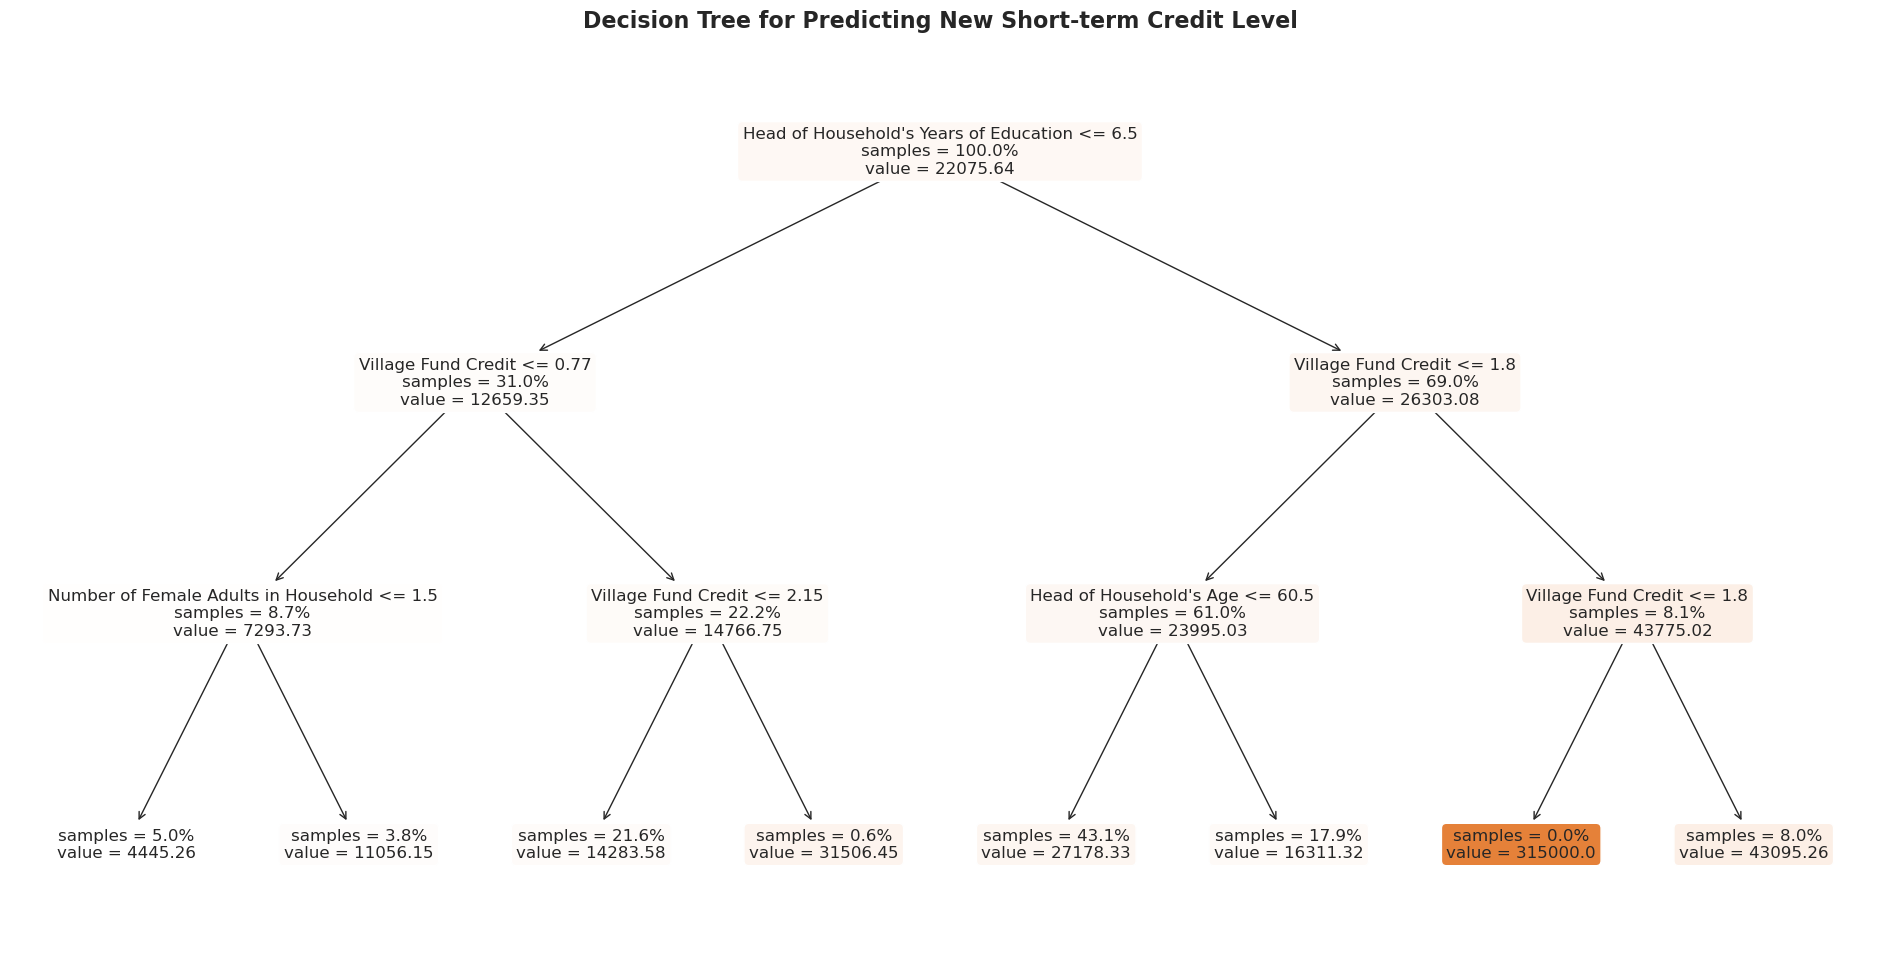

In [133]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score 
import matplotlib.pyplot as plt

# Assume df_reset and result are already defined
df_reset['vfst_hat'] = result.fitted_values

# Define the feature matrix (X) with renamed variables for clarity, without modifying df_reset
X = df_reset[['vfst_hat', 'madult', 'fadult', 'kids', 'maleh', 'farm', 'ageh', 'educh'] + list(year_dummies.columns)].copy()
X.rename(columns={
    'vfst_hat': 'Village Fund Credit',
    'madult': 'Number of Male Adults in Household',
    'fadult': 'Number of Female Adults in Household',
    'kids': 'Number of Kids in Household',
    'maleh': 'Male Head of Household Dummy',
    'ageh': 'Head of Household\'s Age',
    'educh': 'Head of Household\'s Years of Education',
    'farm': 'Occupation (Farmer vs. Non-Farmer)',
    'year_1': 'Year 1',
    'year_2': 'Year 2',
    'year_3': 'Year 3',
    'year_4': 'Year 4',
    'year_5': 'Year 5',
    'year_6': 'Year 6',
    'year_7': 'Year 7',
}, inplace=True)

# Define the target variable (y)
y = df_reset['newst']  # New Short-term Credit Level

# Drop rows with any NaN values in X or y
X = X.dropna()
y = y.loc[X.index]  # Ensure y aligns with the rows in X

# Initialize and fit the DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(X, y)

# Make predictions
y_pred = tree.predict(X)

# Calculate evaluation metrics and store them
mse_tree = mean_squared_error(y, y_pred)
rmse_tree = np.sqrt(mse_tree)
r_squared_forest = r2_score(y, y_pred)

# Plot the decision tree with improved aesthetics
plt.figure(figsize=(24, 12))  # Set a larger figure size for readability
plot_tree(
    tree, 
    feature_names=X.columns, 
    filled=True, 
    rounded=True, 
    fontsize=12, 
    precision=2,  # Limit decimal precision for clarity
    impurity=False,  # Hide impurity to simplify the visual
    proportion=True  # Display 'Samples' as percentages
)
plt.title("Decision Tree for Predicting New Short-term Credit Level", fontsize=16, fontweight='bold')
plt.show()

### Random Forest

Random Forest - Mean Squared Error: 2386860740.6056037
Random Forest - Root Mean Squared Error: 48855.508805104095
Random Forest - R-squared: 0.1639772853684649

Feature Importance Matrix:
                                   Feature  Importance
0                      Village Fund Credit    0.392952
6                  Head of Household's Age    0.236436
7   Head of Household's Years of Education    0.108901
1       Number of Male Adults in Household    0.055502
3              Number of Kids in Household    0.055320
2     Number of Female Adults in Household    0.049480
5       Occupation (Farmer vs. Non-Farmer)    0.026994
13                                  Year 7    0.021103
10                                  Year 4    0.014927
11                                  Year 5    0.013497
4             Male Head of Household Dummy    0.011249
12                                  Year 6    0.010240
9                                   Year 3    0.002529
8                                   Year 

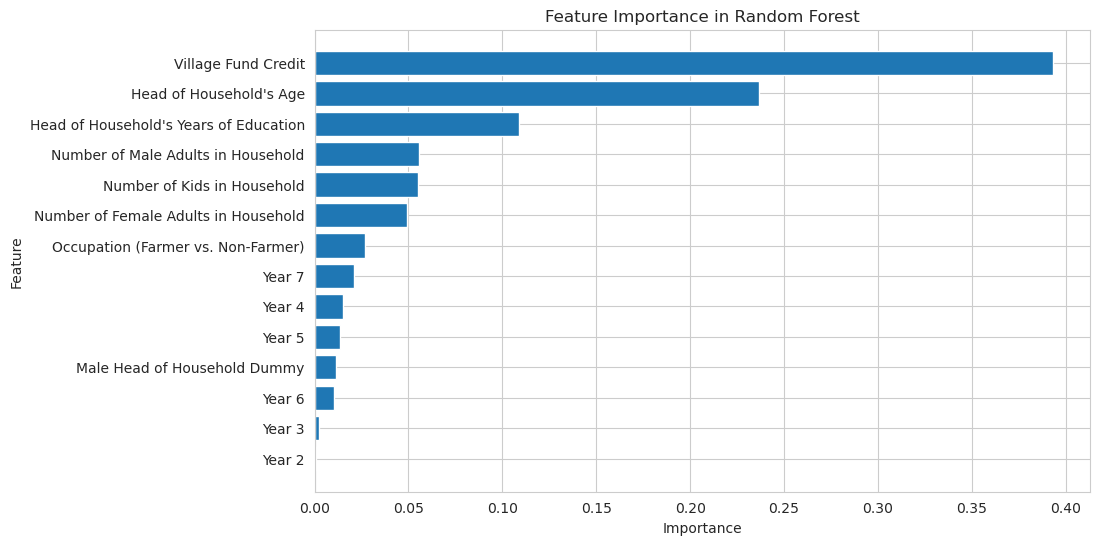

In [134]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize and fit the RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
forest.fit(X, y)

# Make predictions
y_pred_forest = forest.predict(X)

# Calculate evaluation metrics and store them
mse_forest = mean_squared_error(y, y_pred_forest)
rmse_forest = np.sqrt(mse_forest)
r_squared_forest = r2_score(y, y_pred_forest)

# Print evaluation metrics
print(f"Random Forest - Mean Squared Error: {mse_forest}")
print(f"Random Forest - Root Mean Squared Error: {rmse_forest}")
print(f"Random Forest - R-squared: {r_squared_forest}")

# Feature Importance Matrix
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': forest.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance Matrix:")
print(feature_importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

### Boosting

Boosting - Mean Squared Error: 1495585006.5160441
Boosting - Root Mean Squared Error: 38672.79413898153
Boosting - R-squared: 0.4761558494642115

Boosting Feature Importance Matrix:
                                   Feature  Importance
0                      Village Fund Credit    0.527708
6                  Head of Household's Age    0.159990
7   Head of Household's Years of Education    0.094436
3              Number of Kids in Household    0.059416
1       Number of Male Adults in Household    0.059188
5       Occupation (Farmer vs. Non-Farmer)    0.030500
2     Number of Female Adults in Household    0.024369
11                                  Year 5    0.017943
4             Male Head of Household Dummy    0.008878
10                                  Year 4    0.006140
12                                  Year 6    0.005210
8                                   Year 2    0.003032
9                                   Year 3    0.002372
13                                  Year 7    0.

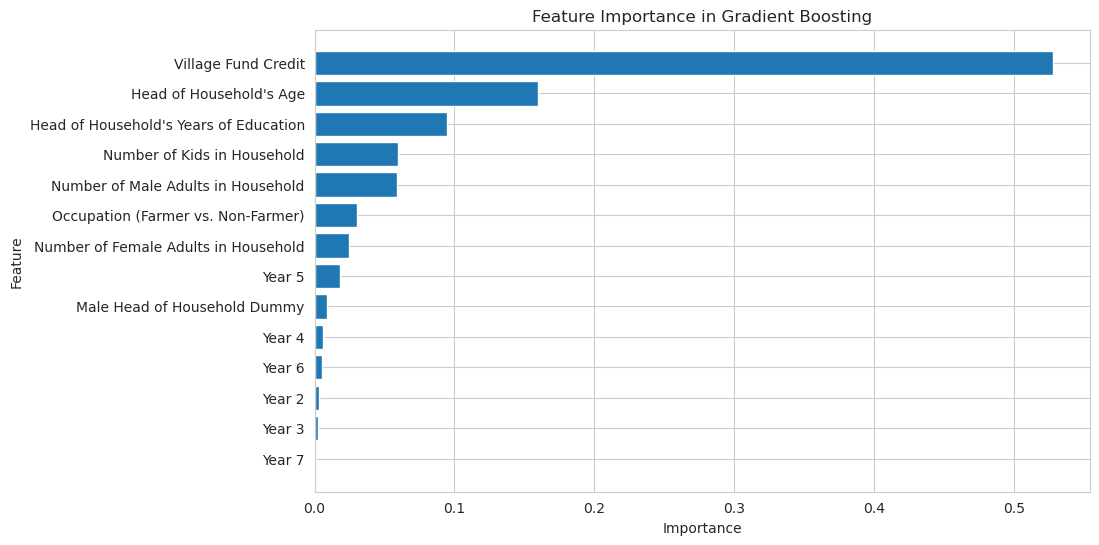

In [135]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming X and y have been preprocessed (e.g., with NaN values handled)

# Initialize and fit the GradientBoostingRegressor
boosting_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=0)
boosting_model.fit(X, y)

# Make predictions
y_pred_boosting = boosting_model.predict(X)

# Calculate evaluation metrics and store them
mse_boosting = mean_squared_error(y, y_pred_boosting)
rmse_boosting = np.sqrt(mse_boosting)
r_squared_boosting = r2_score(y, y_pred_boosting)

# Print evaluation metrics for Boosting
print(f"Boosting - Mean Squared Error: {mse_boosting}")
print(f"Boosting - Root Mean Squared Error: {rmse_boosting}")
print(f"Boosting - R-squared: {r_squared_boosting}")

# Feature Importance Matrix for Boosting
feature_importances_boosting = pd.DataFrame({
    'Feature': X.columns,
    'Importance': boosting_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nBoosting Feature Importance Matrix:")
print(feature_importances_boosting)

# Plot the feature importances for Boosting
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_boosting['Feature'], feature_importances_boosting['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Gradient Boosting")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

### Bagging

Bagging - Mean Squared Error: 2386863179.556536
Bagging - Root Mean Squared Error: 48855.53376595671
Bagging - R-squared: 0.16397643110062055

Bagging Feature Importance Matrix (Averaged from Base Estimators):
                                   Feature  Importance
0                      Village Fund Credit    0.391130
6                  Head of Household's Age    0.240495
7   Head of Household's Years of Education    0.107694
1       Number of Male Adults in Household    0.059592
3              Number of Kids in Household    0.048757
2     Number of Female Adults in Household    0.048122
5       Occupation (Farmer vs. Non-Farmer)    0.027049
10                                  Year 4    0.023510
13                                  Year 7    0.019352
11                                  Year 5    0.011950
4             Male Head of Household Dummy    0.010252
12                                  Year 6    0.008545
9                                   Year 3    0.002534
8                   

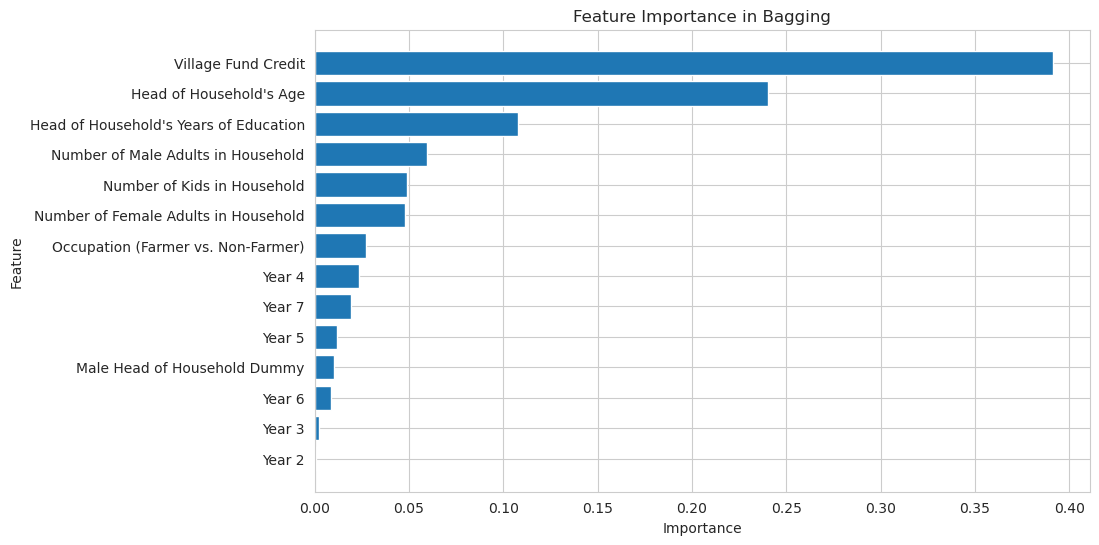

In [136]:
import numpy as np
import pandas as pd
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize and fit the BaggingRegressor using DecisionTreeRegressor as the base estimator
bagging_model = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=100,
    random_state=0
)
bagging_model.fit(X, y)

# Make predictions with the Bagging model
y_pred_bagging = bagging_model.predict(X)

# Calculate evaluation metrics and store them
mse_bagging = mean_squared_error(y, y_pred_bagging)
rmse_bagging = np.sqrt(mse_bagging)
r_squared_bagging = r2_score(y, y_pred_bagging)

# Print evaluation metrics for Bagging
print(f"Bagging - Mean Squared Error: {mse_bagging}")
print(f"Bagging - Root Mean Squared Error: {rmse_bagging}")
print(f"Bagging - R-squared: {r_squared_bagging}")

# Extract feature importances from each tree and average them
feature_importances = np.mean([tree.feature_importances_ for tree in bagging_model.estimators_], axis=0)

# Create a feature importance DataFrame
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importance matrix
print("\nBagging Feature Importance Matrix (Averaged from Base Estimators):")
print(feature_importances_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Bagging")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

### Performance Evaluation 

In [141]:
import pandas as pd

# Create a DataFrame to summarize the error metrics for each model
error_comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Boosting', 'Bagging'],
    'MSE': [mse_tree, mse_forest, mse_boosting, mse_bagging],
    'RMSE': [rmse_tree, rmse_forest, rmse_boosting, rmse_bagging]
})

# Display the error comparison table
print("\nError Comparison Table:")
print(error_comparison)


Error Comparison Table:
           Model           MSE          RMSE
0  Decision Tree  2.751383e+09  52453.626920
1  Random Forest  2.386861e+09  48855.508805
2       Boosting  1.495585e+09  38672.794139
3        Bagging  2.386863e+09  48855.533766


### LASSO Regression

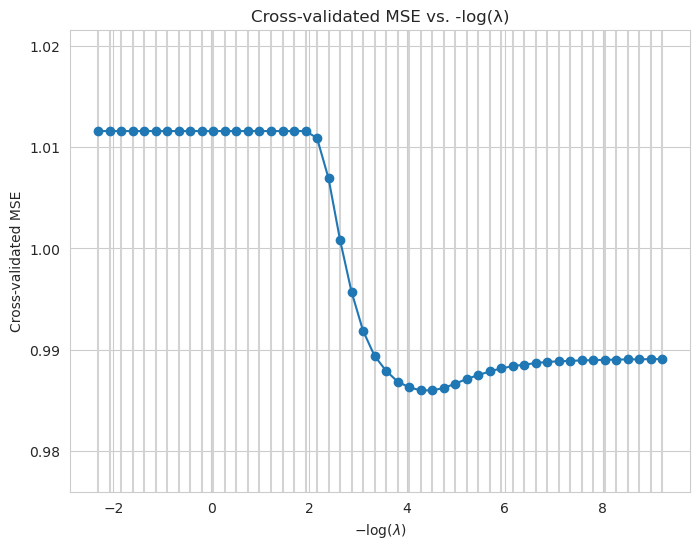

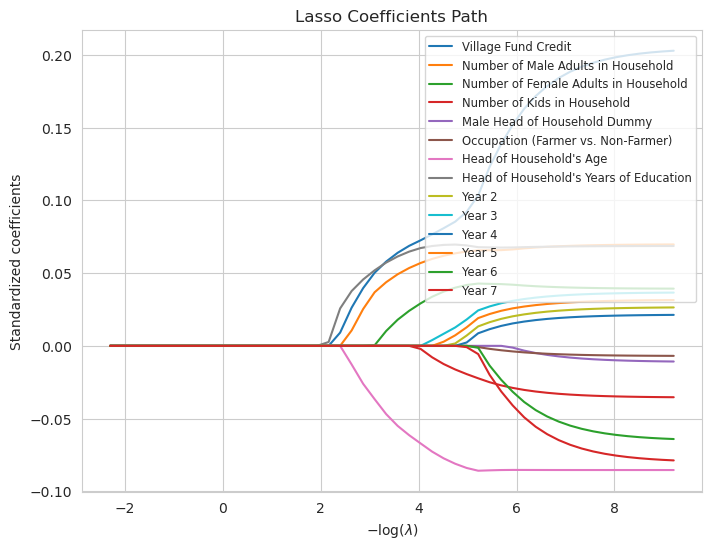

In [138]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV, lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Standardize X and y to ensure clear coefficient paths and scaled MSE values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = (y - y.mean()) / y.std()  # Manually standardizing y if necessary

# Initialize and fit LassoCV with cross-validation for selecting the best lambda
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, random_state=0)
lasso_cv.fit(X_scaled, y_scaled)

# Cross-validated MSE vs -log(alpha) plot with error bars
mse_path_mean = lasso_cv.mse_path_.mean(axis=1)  # Average MSE across folds
mse_path_std = lasso_cv.mse_path_.std(axis=1)  # Standard deviation across folds for error bars
log_alphas_cv = -np.log(lasso_cv.alphas_)  # -log(lambda)

plt.figure(figsize=(8, 6))
plt.errorbar(log_alphas_cv, mse_path_mean, yerr=mse_path_std, fmt='o-', ecolor='lightgray', capsize=3)
plt.xlabel(r"$-\log(\lambda)$")
plt.ylabel("Cross-validated MSE")
plt.title("Cross-validated MSE vs. -log(λ)")

# Set y-axis limits to zoom in on the relevant range
plt.ylim(mse_path_mean.min() - 0.01, mse_path_mean.max() + 0.01)

plt.grid(True)
plt.show()

# Plot LASSO Coefficients Path
alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled, y_scaled, alphas=np.logspace(-4, 1, 50))
log_alphas_path = -np.log(alphas_lasso)  # -log(lambda) for the path

plt.figure(figsize=(8, 6))
for i, feature in enumerate(X.columns):
    plt.plot(log_alphas_path, coefs_lasso[i], label=feature)
plt.xlabel(r"$-\log(\lambda)$")
plt.ylabel("Standardized coefficients")
plt.title("Lasso Coefficients Path")
plt.legend(loc="upper right", fontsize='small')
plt.grid(True)
plt.show()

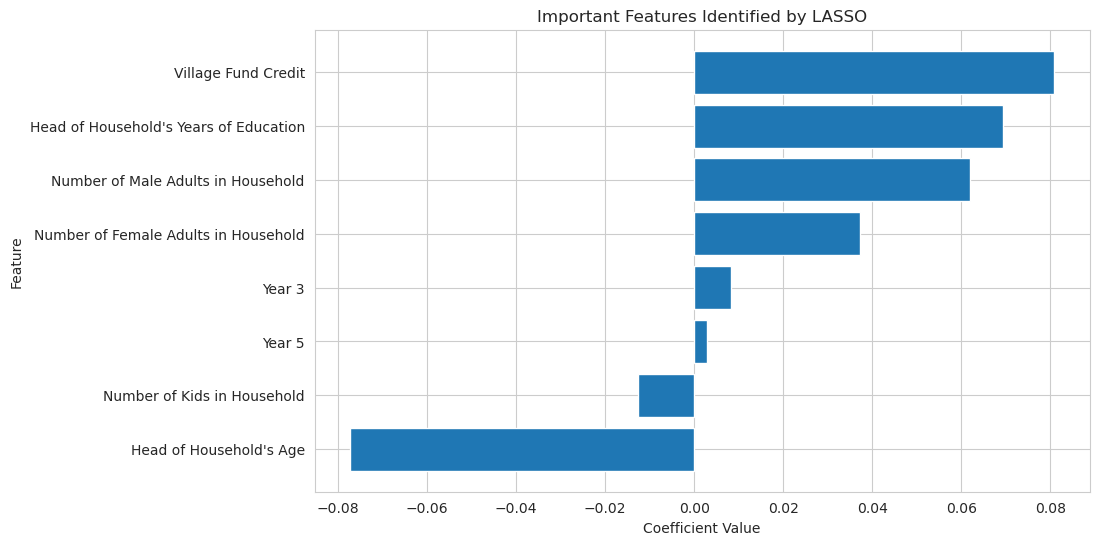

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Standardize X and y to ensure clear coefficient paths and scaled MSE values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = (y - y.mean()) / y.std()  # Standardize y if necessary

# Initialize and fit LassoCV with cross-validation for selecting the best lambda
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, random_state=0)
lasso_cv.fit(X_scaled, y_scaled)

# Get the coefficients from the best model and identify non-zero coefficients
important_features = X.columns[lasso_cv.coef_ != 0]
important_coefficients = lasso_cv.coef_[lasso_cv.coef_ != 0]

# Create a DataFrame for easier plotting and sorting
important_features_df = pd.DataFrame({
    'Feature': important_features,
    'Coefficient': important_coefficients
}).sort_values(by='Coefficient', ascending=False)

# Plot the important features
plt.figure(figsize=(10, 6))
plt.barh(important_features_df['Feature'], important_features_df['Coefficient'])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Important Features Identified by LASSO")
plt.gca().invert_yaxis()  # Invert y-axis to have the largest coefficient at the top
plt.grid(True)
plt.show()

### Ridge Regression

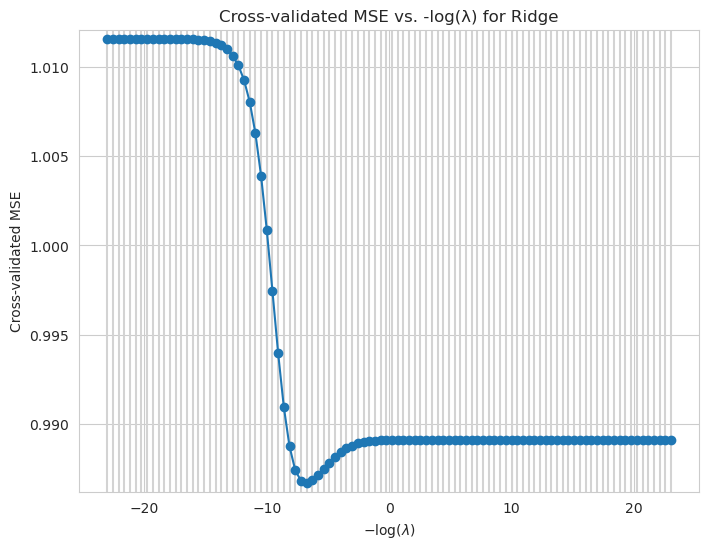

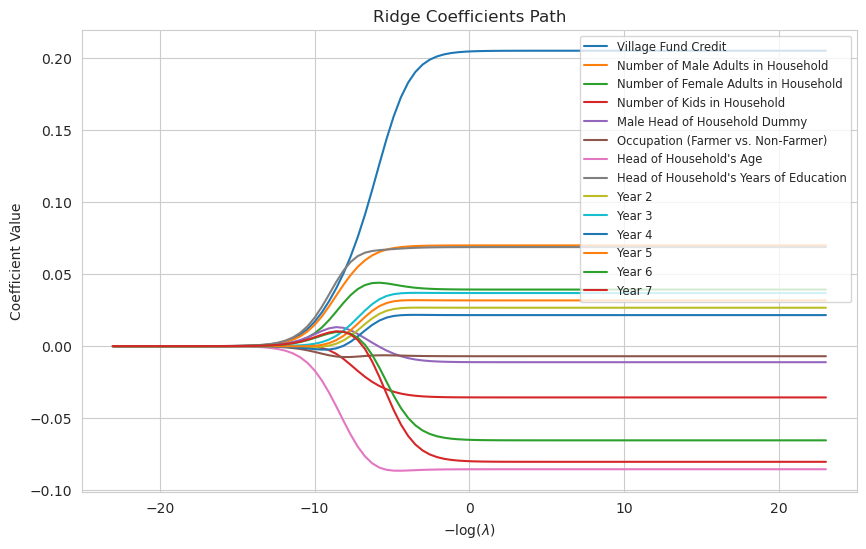

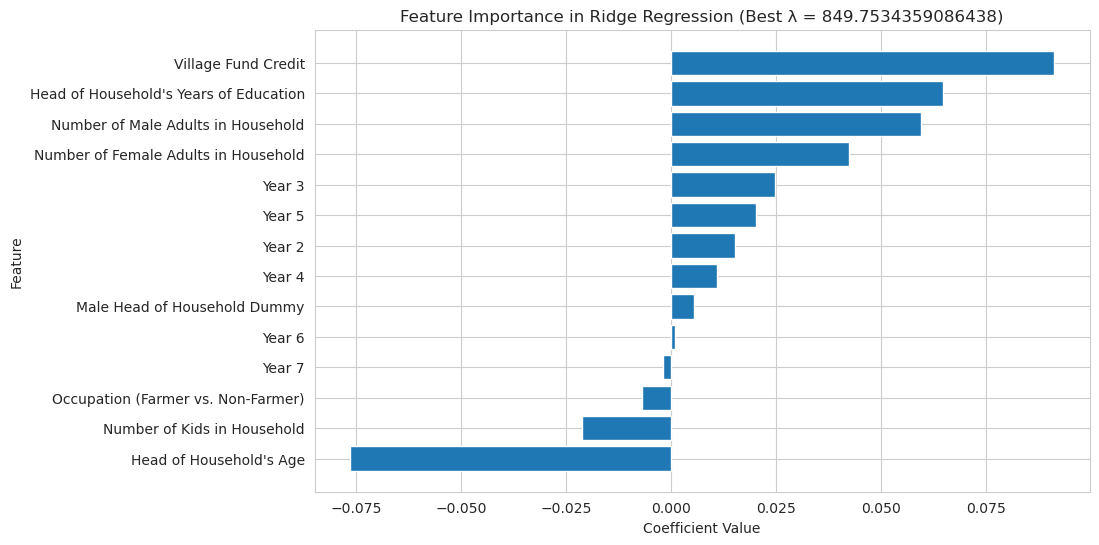

In [140]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize X and y to ensure consistent coefficient scaling and scaled MSE values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = (y - y.mean()) / y.std()  # Manually standardizing y if necessary

# Define a range of alphas for Ridge
alphas_ridge = np.logspace(-10, 10, 100)

# Initialize lists to store the mean and std of cross-validated MSEs
mse_mean = []
mse_std = []

# Perform cross-validation manually for each alpha
for alpha in alphas_ridge:
    ridge = Ridge(alpha=alpha)
    neg_mse_scores = cross_val_score(ridge, X_scaled, y_scaled, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -neg_mse_scores  # Convert to positive MSE
    mse_mean.append(mse_scores.mean())
    mse_std.append(mse_scores.std())

# Convert lists to arrays for plotting
mse_mean = np.array(mse_mean)
mse_std = np.array(mse_std)
log_alphas = -np.log(alphas_ridge)

# 1. Cross-validated MSE vs -log(alpha) plot with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(log_alphas, mse_mean, yerr=mse_std, fmt='o-', ecolor='lightgray', capsize=3)
plt.xlabel(r"$-\log(\lambda)$")
plt.ylabel("Cross-validated MSE")
plt.title("Cross-validated MSE vs. -log(λ) for Ridge")
# Adjust y-axis range for better focus
plt.ylim(mse_mean.min() - 0.0005, mse_mean.max() + 0.0005)
plt.grid(True)
plt.show()

# 2. Ridge Coefficients Path
coefs_ridge = []
for alpha in alphas_ridge:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, y_scaled)
    coefs_ridge.append(ridge.coef_)

log_alphas_path = -np.log(alphas_ridge)  # -log(lambda)

plt.figure(figsize=(10, 6))  # Increase figure width for more space
for i, feature in enumerate(X.columns):
    plt.plot(log_alphas_path, [coef[i] for coef in coefs_ridge], label=feature)
plt.xlabel(r"$-\log(\lambda)$")
plt.ylabel("Coefficient Value")
plt.title("Ridge Coefficients Path")
plt.legend(loc="upper right", fontsize='small')
# Extend x-axis range to show more space on the right side
plt.xlim(log_alphas_path.min() - 2, log_alphas_path.max() + 2)
plt.grid(True)
plt.show()

# 3. Important Features Plot
# Get the coefficients from the Ridge model with the best alpha
best_alpha = alphas_ridge[np.argmin(mse_mean)]
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_scaled, y_scaled)

important_features = X.columns
important_coefficients = ridge_best.coef_

important_features_df = pd.DataFrame({
    'Feature': important_features,
    'Coefficient': important_coefficients
}).sort_values(by='Coefficient', ascending=False)

# Plot the important features
plt.figure(figsize=(10, 6))
plt.barh(important_features_df['Feature'], important_features_df['Coefficient'])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title(f"Feature Importance in Ridge Regression (Best λ = {best_alpha})")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()